# Numenta Anomaly Benchmark

### Dataset
* machine_temperature_system_failure.csv
    * Temperature sensor data of an internal component of a large, industrial machine.
    * The first anomaly is a planned shutdown of the machine.
    * The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.
    
### Model
* Long Short-Term Memory (LSTM) Autoencoder
    * Long short-term memory (LSTM) is a recurrent neural network (RNN) architecture, used to process entire sequences of data.
    * An autoencoder learns a representation for a set of data in an unsupervised manner by training the network to ignore signal “noise”.
    * The reconstruction error serves as an indicator to the extent of a data instance being an anomaly.

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Silencing FutureWarning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from util.utils import *
from model.models import *

Using TensorFlow backend.


,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


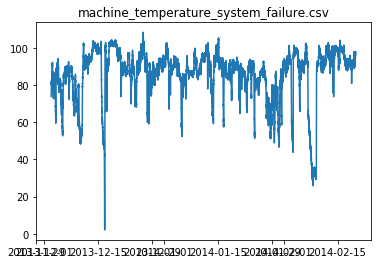

In [2]:
# Import data
df = pd.read_csv("../data/machine_temperature_system_failure.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
display(df.head(5))

# Visualise data
plt.plot(df)
plt.title("machine_temperature_system_failure.csv")
plt.show()

In [3]:
# Create a trajectory matrix, i.e. rolling window representation
timeseries = df['value']
traj_mat = get_window(timeseries, backward=4)
traj_mat

array([[73.96732207, 74.935882  , 76.12416182, 78.14070732, 79.32983574],
       [74.935882  , 76.12416182, 78.14070732, 79.32983574, 78.71041827],
       [76.12416182, 78.14070732, 79.32983574, 78.71041827, 80.26978421],
       ...,
       [98.16295219, 97.36090483, 98.18541493, 97.80416849, 97.13546835],
       [97.36090483, 98.18541493, 97.80416849, 97.13546835, 98.05685212],
       [98.18541493, 97.80416849, 97.13546835, 98.05685212, 96.90386085]])

In [5]:
lae = LSTMAutoEncoder()
lae.fit(traj_mat)
scores = lae.predict(traj_mat)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 67,205
Trainable params: 67,205
Non-trainable params: 0
_________________________________________________________________
None
Train on 18152 samples, validate on 4539 samples
Epoch 1/5
18152/18152 [==============================] - 14s 781us/step - loss: 1316.2740 - mean_absolute_error: 25.1760 - val_loss: 21.0299 - val_mean_absolute_error: 3.4457
Epoch 2/5
18152/18152 [==============================] - 13s 709us/step - loss: 4.0560 - mean_absolute_error: 1.1797 - val_loss: 1.0981 - val_mean_absolute_error: 0.7501
Epoch 3/5
18152/18152 [==============================] - 13s 741us/step - loss: 1.1206 - mean_absolute_error: 0.7428 - val_loss: 1.0888

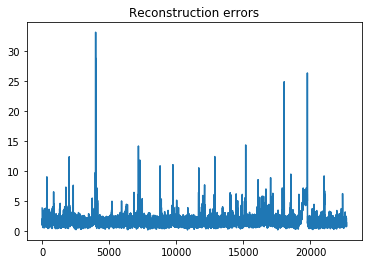

In [6]:
plt.plot(scores)
plt.title("Reconstruction errors")
plt.show()